In [2]:
import os
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np

In [49]:
# ### V1: 2021-07-28 - 

# ## Read the list of unique patient IDs
# dir_path = '/home/jagh/Documents/01_UB/MultiOmiX/patientomics/data/05_data_exploration/01_preprocessing_116_PLCP/'
# filename = os.path.join(dir_path, '116_plcp_mv_pseudoid_pid.csv')
# df = pd.read_csv(filename, sep=',', header=0)

# ## Read the CSV file into a DataFrame
# lab_dict_dirpath = '/home/jagh/Documents/01_UB/MultiOmiX/patientomics/data/dicts/'
# lab_dict_filename = os.path.join(lab_dict_dirpath, 'lab_data_dict.csv')
# df_lab_dict = pd.read_csv(lab_dict_filename, sep=',', header=0, index_col=0)
# print('df_lab_dict', df_lab_dict)

# ## Dataframe to store the lab markers
# patients_labmarkers_df = pd.DataFrame()

# for row in df.itertuples(5):
#     patient_id = row.pseudoid_pid
#     ## Read the folder with the lab markers
#     dir_lab_path = '/home/jagh/Documents/01_UB/MultiOmiX/patientomics/data/06_clinical_data/lab_data_features/'
#     filename = os.path.join(dir_lab_path, 'patient_'+ str(patient_id) +'.csv')

#     try:
#         ## Read the CSV file into a DataFrame per patient
#         df_lab = pd.read_csv(filename, sep=',', header=0, index_col=0)
#         print('+ patient_id: ', patient_id, df_lab.shape)

#         ## Added the patient ID to the dataframe and append the corrsponding lab markers to the lab dictionary
#         for row_labdata in df_lab.itertuples():
#             print('row_labdata', row_labdata)
#             print('row_labdata', type(row_labdata))

#             ## Add the row_labdata into patients_labmarkers_df

#     ## make an exception for FileNotFoundError
#     except FileNotFoundError:
#         print('- patient_id: ', patient_id)
#         continue
    
# # ## Save the dataframe to a CSV file
# # filename = os.path.join(dir_path, '116_plcp_mv_pseudoid_pid_lab.csv')
# # df_lab.to_csv(filename, sep=',', header=True, index=False)

# print(df_lab)
# print(df_lab.shape)

In [46]:
# ### V2: 2021-07-28 - Saving only one row per patient_id (the first one)

# import os
# import pandas as pd

# # Read the list of unique patient IDs
# dir_path = '/home/jagh/Documents/01_UB/MultiOmiX/patientomics/data/05_data_exploration/01_preprocessing_116_PLCP/'
# filename = os.path.join(dir_path, '116_plcp_mv_pseudoid_pid.csv')
# df = pd.read_csv(filename, sep=',', header=0)

# # Read the lab markers dictionary
# lab_dict_dirpath = '/home/jagh/Documents/01_UB/MultiOmiX/patientomics/data/dicts/'
# lab_dict_filename = os.path.join(lab_dict_dirpath, 'lab_data_dict.csv')
# df_lab_markers = pd.read_csv(lab_dict_filename, sep=',', header=0, index_col=0)

# # Iterate through the patient IDs
# for row in df.itertuples():
#     patient_id = row.pseudoid_pid
#     dir_lab_path = '/home/jagh/Documents/01_UB/MultiOmiX/patientomics/data/06_clinical_data/lab_data_features/'
#     filename = os.path.join(dir_lab_path, f'patient_{patient_id}.csv')

#     try:
#         # Read the CSV file into a DataFrame per patient
#         df_lab = pd.read_csv(filename, sep=',', header=0)   #, index_col=0)

#         # ## Print the days for the row 0
#         # print(df_lab.iloc[0])
        
#         # Append the laboratory values to df_lab_markers using the corresponding column names per each day 'days' at each patient_id
#         for col in df_lab.columns:
#             df_lab_markers.loc[patient_id, col] = df_lab[col].values[0] if col in df_lab.columns else None
    
#     # Make an exception for FileNotFoundError
#     except FileNotFoundError:
#         continue

# # Save the updated df_lab_markers to a CSV file
# updated_lab_markers_filename = os.path.join(dir_path, '999_116_plcp_lab_markers.csv')
# df_lab_markers.to_csv(updated_lab_markers_filename, sep=',', header=True, index=True)

# # Print some information about the updated dataframe
# print('Updated df_lab_markers:')
# print(df_lab_markers)
# print('Shape:', df_lab_markers.shape)

In [13]:
import os
import pandas as pd

# Read the list of unique patient IDs
dir_path = '/home/jagh/Documents/01_UB/MultiOmiX/patientomics/data/05_data_exploration/01_preprocessing_116_PLCP/'
filename = os.path.join(dir_path, '116_plcp_mv_pseudoid_pid.csv')
df = pd.read_csv(filename, sep=',', header=0)

# Read the lab markers dictionary
lab_dict_dirpath = '/home/jagh/Documents/01_UB/MultiOmiX/patientomics/data/dicts/'
lab_dict_filename = os.path.join(lab_dict_dirpath, 'lab_data_dict.csv')
df_lab_markers = pd.read_csv(lab_dict_filename, sep=',', header=0, index_col=0)

# Iterate through the patient IDs
for row in df.itertuples():
    patient_id = row.pseudoid_pid
    dir_lab_path = '/home/jagh/Documents/01_UB/MultiOmiX/patientomics/data/06_clinical_data/lab_data_features/'
    filename = os.path.join(dir_lab_path, f'patient_{patient_id}.csv')

    try:
        # Read the first row of the CSV file into a DataFrame per patient
        # df_lab = pd.read_csv(filename, sep=',', nrows=1, header=0)  # Read only the first row
        df_lab = pd.read_csv(filename, sep=',', nrows=1, header=0)  # Read only the first row

        # Append the laboratory values to df_lab_markers using the corresponding column names per the days column
        days_col = df_lab['days'].iloc[0]
        for col in df_lab.columns:
            df_lab_markers.loc[patient_id, f"{col}_{days_col}"] = df_lab[col].iloc[0] if col in df_lab.columns else None
    
    # Make an exception for FileNotFoundError
    except FileNotFoundError:
        continue

## set Nan values to 0
df_lab_markers = df_lab_markers.fillna(0)

# Save the updated df_lab_markers to a CSV file
updated_lab_markers_filename = os.path.join(dir_path, '999_116_plcp_lab_markers.csv')
df_lab_markers.to_csv(updated_lab_markers_filename, sep=',', header=True, index=True)

# Print some information about the updated dataframe
print('Updated df_lab_markers:')
print(df_lab_markers)
print('Shape:', df_lab_markers.shape)

KeyError: 'days'

Number of NaN values: 0
Number of infinite values: 0


/home/jagh/anaconda3/envs/patientomics/lib/python3.9/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


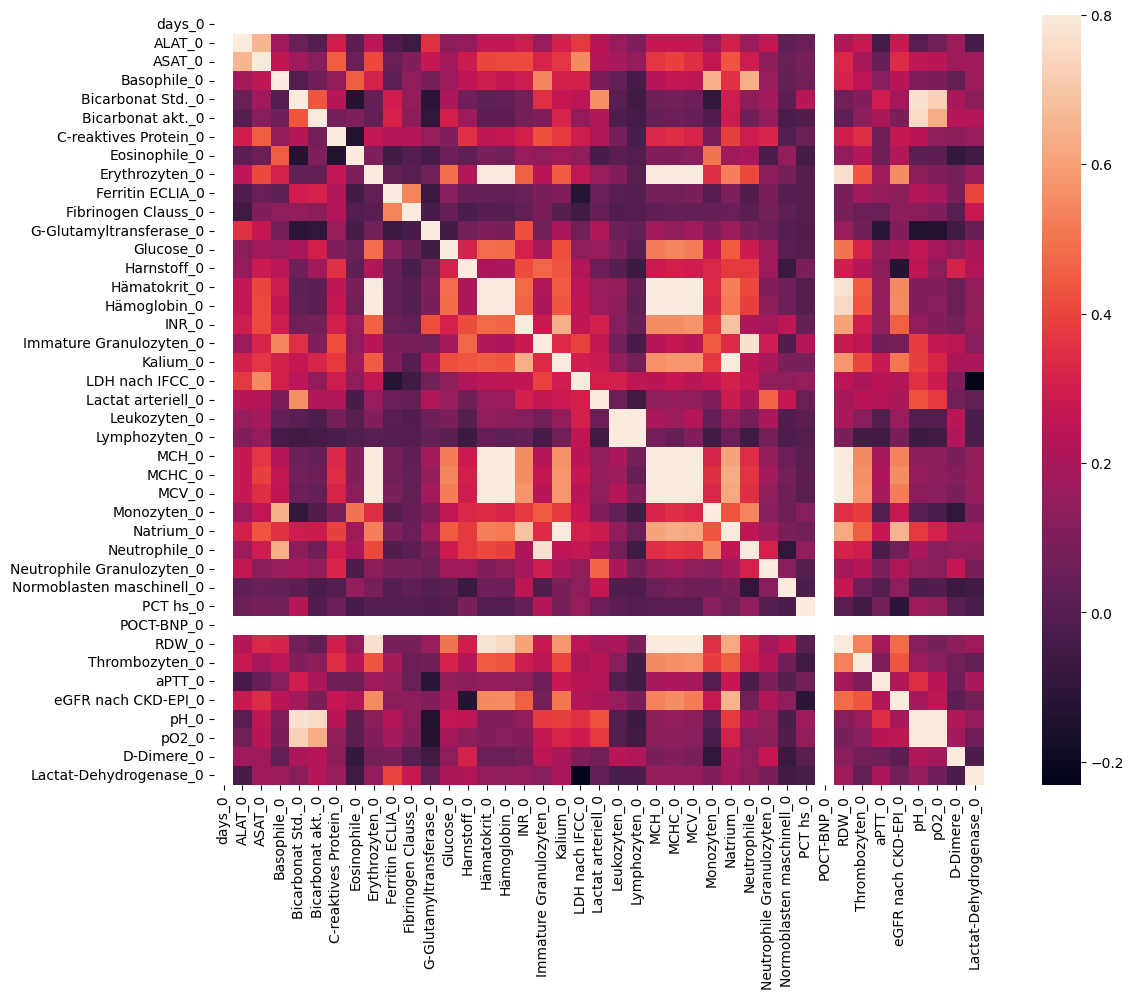

In [4]:
import os
import pandas as pd
import numpy as np
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import manifold
from sklearn.metrics import euclidean_distances
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


# Load data
dir_path = '/home/jagh/Documents/01_UB/MultiOmiX/patientomics/data/05_data_exploration/01_preprocessing_116_PLCP/'
filename = os.path.join(dir_path, 'lab_data_exploration.csv')
df = pd.read_csv(filename, sep=',', header=0, index_col=0)

# Extract the feature columns
feature_names = df.columns

# Extract the sample ids
samples = df.values

# Standardize the data before calculating distances
scaler = StandardScaler()
scaled_samples = scaler.fit_transform(samples)

# Calculate pairwise Euclidean distances
similarities = euclidean_distances(scaled_samples, scaled_samples)

# Debugging: Output non-finite values in the similarities matrix
print("Number of NaN values:", np.sum(np.isnan(similarities)))
print("Number of infinite values:", np.sum(np.isinf(similarities)))

# Replace NaN with infinity
similarities[np.isnan(similarities)] = np.inf

# Multidimensional scaling
seed = np.random.RandomState(seed=3)
mds = manifold.MDS(n_components=2, max_iter=5000, eps=1e-12, random_state=seed,
                   n_init=10, dissimilarity="precomputed", n_jobs=1, metric=False)
pos = mds.fit_transform(similarities)

### features as a heatmap
# Construct a pandas dataframe from the samples
d = pd.DataFrame(data=samples, columns=feature_names)
corr = d.corr()

# Set up the matplotlib figure, make it big!
f, ax = plt.subplots(figsize=(15, 10))

# Draw the heatmap using seaborn
sns.heatmap(corr, vmax=.8, square=True)


plt.show()

Number of NaN values: 0
Number of infinite values: 0


<Figure size 1500x1000 with 0 Axes>

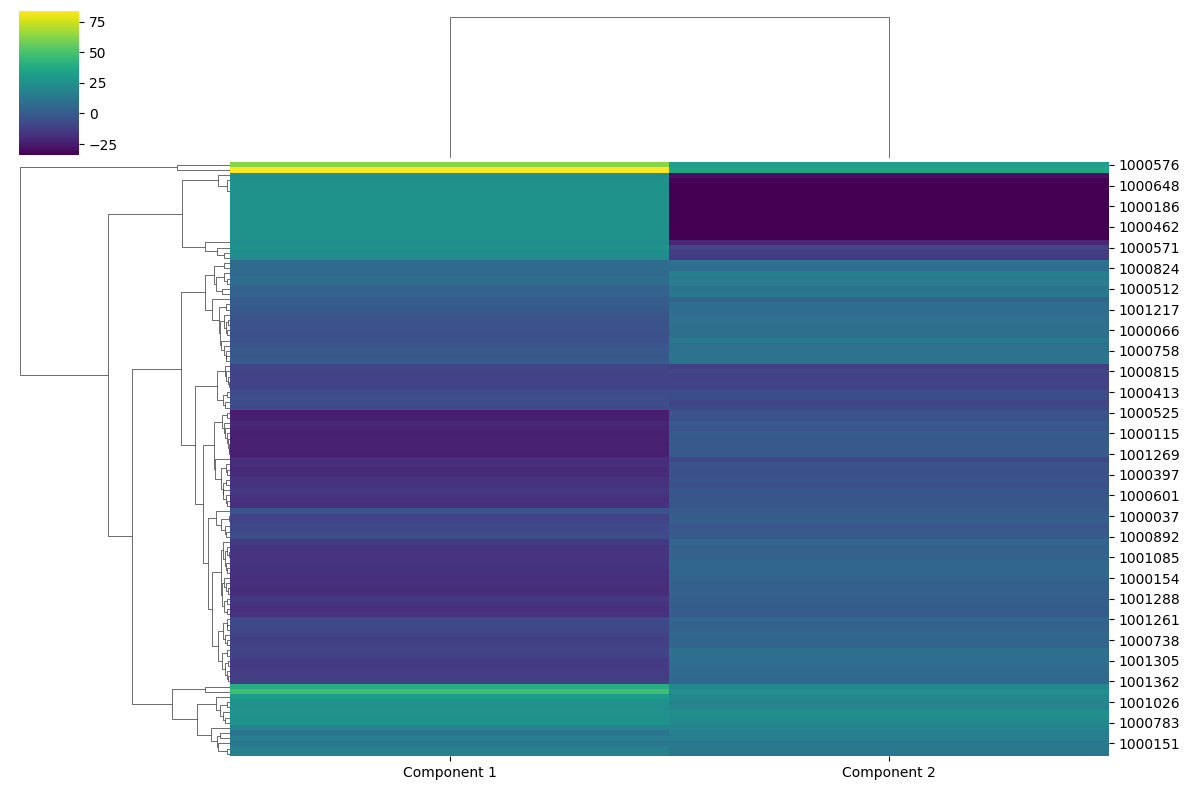

In [5]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import euclidean_distances
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Load data
dir_path = '/home/jagh/Documents/01_UB/MultiOmiX/patientomics/data/05_data_exploration/01_preprocessing_116_PLCP/'
filename = os.path.join(dir_path, 'lab_data_exploration.csv')
df = pd.read_csv(filename, sep=',', header=0, index_col=0)

# Extract the feature columns and sample data
feature_names = df.columns
samples = df.values

# Extract patients ids
patient_ids = df.index.values

# Standardize the data before calculating distances
scaler = StandardScaler()
scaled_samples = scaler.fit_transform(samples)

# Calculate pairwise Euclidean distances
similarities = euclidean_distances(scaled_samples)

# Debugging: Output non-finite values in the similarities matrix
nan_count = np.sum(np.isnan(similarities))
inf_count = np.sum(np.isinf(similarities))
print("Number of NaN values:", nan_count)
print("Number of infinite values:", inf_count)

# Replace NaN with infinity
similarities[np.isnan(similarities)] = np.inf

# Multidimensional scaling
seed = np.random.RandomState(seed=3)
mds = PCA(n_components=2, random_state=seed)
pos = mds.fit_transform(similarities)

# Create a DataFrame with the MDS positions and patient IDs
mds_df = pd.DataFrame(pos, columns=['Component 1', 'Component 2'], index=patient_ids)

# Set up the matplotlib figure, make it big!
plt.figure(figsize=(15, 10))

# Create a cluster map using seaborn
sns.clustermap(mds_df, cmap='viridis', method='average', metric='euclidean', figsize=(12, 8))

plt.show()

Number of NaN values: 0
Number of infinite values: 0


<Figure size 1500x1000 with 0 Axes>

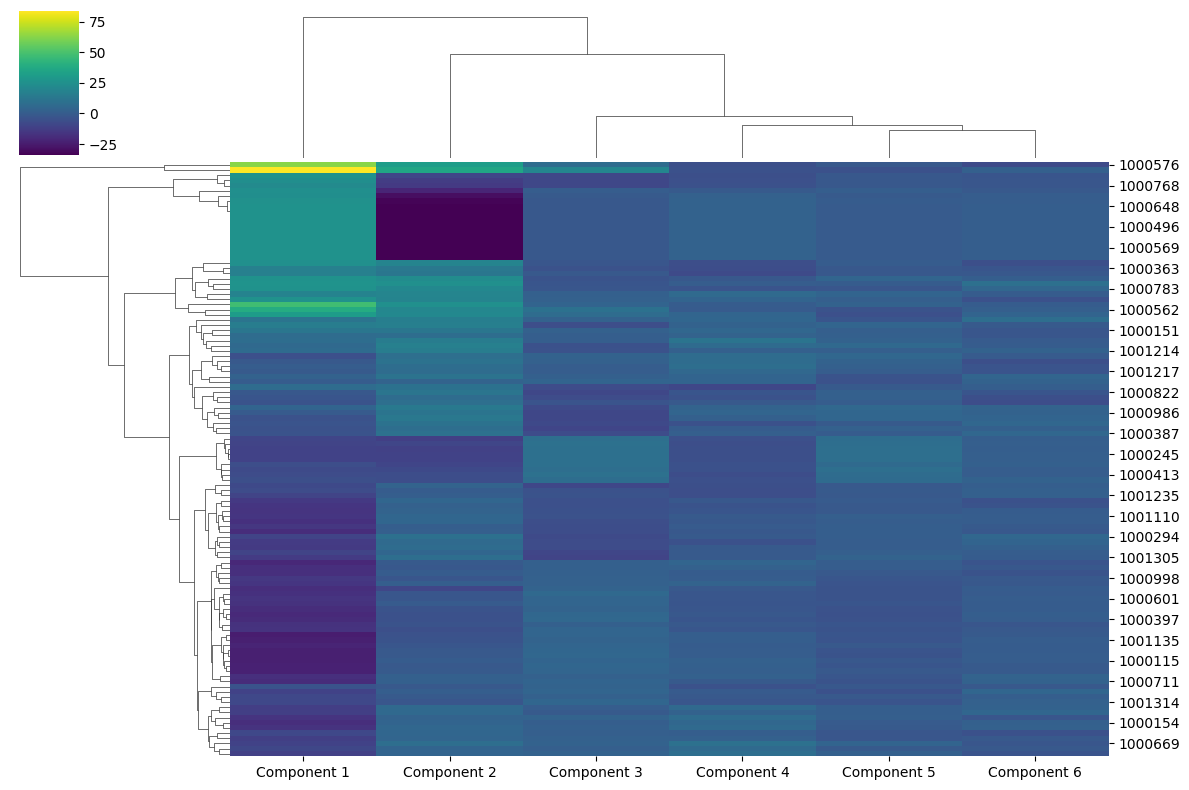

In [6]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import euclidean_distances
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Load data
dir_path = '/home/jagh/Documents/01_UB/MultiOmiX/patientomics/data/05_data_exploration/01_preprocessing_116_PLCP/'
filename = os.path.join(dir_path, 'lab_data_exploration.csv')
df = pd.read_csv(filename, sep=',', header=0, index_col=0)

# Extract the feature columns and sample data
feature_names = df.columns
samples = df.values

# Extract patients ids
patient_ids = df.index.values

# Standardize the data before calculating distances
scaler = StandardScaler()
scaled_samples = scaler.fit_transform(samples)

# Calculate pairwise Euclidean distances
similarities = euclidean_distances(scaled_samples)

# Debugging: Output non-finite values in the similarities matrix
nan_count = np.sum(np.isnan(similarities))
inf_count = np.sum(np.isinf(similarities))
print("Number of NaN values:", nan_count)
print("Number of infinite values:", inf_count)

# Replace NaN with infinity
similarities[np.isnan(similarities)] = np.inf

# Multidimensional scaling
seed = np.random.RandomState(seed=3)
mds = PCA(n_components=6, random_state=seed)  # Using 6 components
pos = mds.fit_transform(similarities)

# Create a DataFrame with the MDS positions and patient IDs
mds_df = pd.DataFrame(pos, columns=[f'Component {i+1}' for i in range(6)], index=patient_ids)

# Set up the matplotlib figure, make it big!
plt.figure(figsize=(15, 10))

# Create a cluster map using seaborn
sns.clustermap(mds_df, cmap='viridis', method='average', metric='euclidean', figsize=(12, 8))

plt.show()

Number of NaN values: 0
Number of infinite values: 0


/home/jagh/anaconda3/envs/patientomics/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/jagh/anaconda3/envs/patientomics/lib/python3.9/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/home/jagh/anaconda3/envs/patientomics/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/jagh/anaconda3/envs/patientomics/lib/python3.9/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=sel

<Figure size 1500x1000 with 0 Axes>

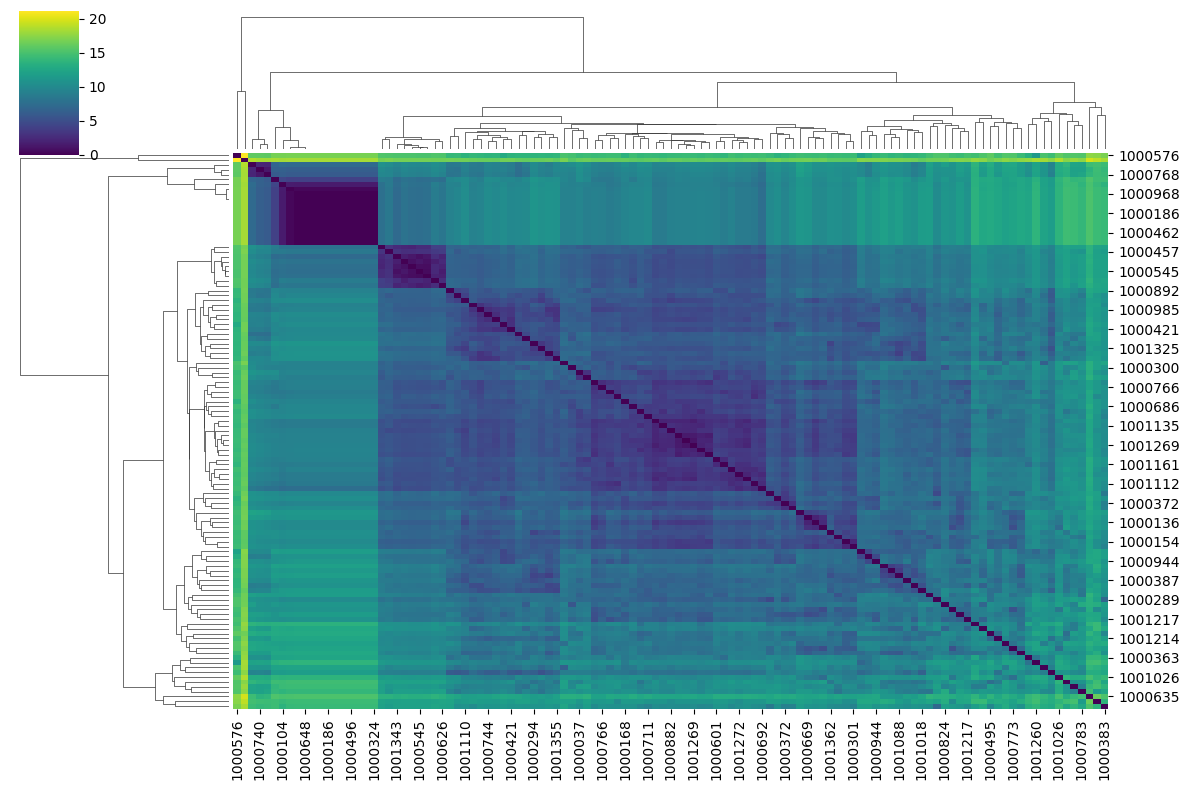

In [7]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import euclidean_distances
from sklearn.preprocessing import StandardScaler

# Load data
dir_path = '/home/jagh/Documents/01_UB/MultiOmiX/patientomics/data/05_data_exploration/01_preprocessing_116_PLCP/'
filename = os.path.join(dir_path, 'lab_data_exploration.csv')
df = pd.read_csv(filename, sep=',', header=0, index_col=0)

# Extract the feature columns and sample data
feature_names = df.columns
samples = df.values

# Extract patients ids
patient_ids = df.index.values

# Standardize the data before calculating distances
scaler = StandardScaler()
scaled_samples = scaler.fit_transform(samples)

# Calculate pairwise Euclidean distances
similarities = euclidean_distances(scaled_samples)

# Debugging: Output non-finite values in the similarities matrix
nan_count = np.sum(np.isnan(similarities))
inf_count = np.sum(np.isinf(similarities))
print("Number of NaN values:", nan_count)
print("Number of infinite values:", inf_count)

# Replace NaN with infinity
similarities[np.isnan(similarities)] = np.inf

# Create a DataFrame with the similarities and feature names
similarities_df = pd.DataFrame(similarities, columns=patient_ids, index=patient_ids)

# Set up the matplotlib figure, make it big!
plt.figure(figsize=(15, 10))

# Create a cluster map using seaborn
sns.clustermap(similarities_df, cmap='viridis', method='average', metric='euclidean', figsize=(12, 8))

plt.show()

Number of NaN values: 0
Number of infinite values: 0


/home/jagh/anaconda3/envs/patientomics/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/jagh/anaconda3/envs/patientomics/lib/python3.9/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/home/jagh/anaconda3/envs/patientomics/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/jagh/anaconda3/envs/patientomics/lib/python3.9/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=sel

<Figure size 1500x1000 with 0 Axes>

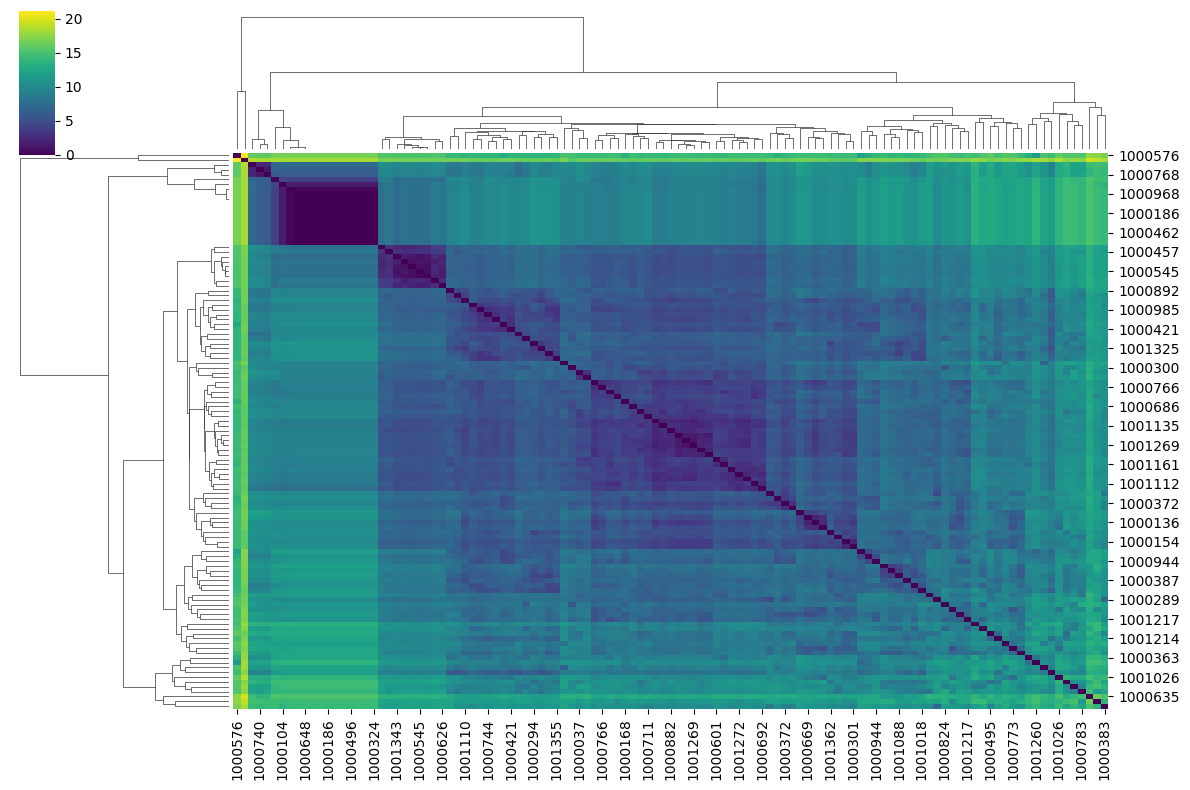

In [8]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import euclidean_distances
from sklearn.preprocessing import StandardScaler

# Load data
dir_path = '/home/jagh/Documents/01_UB/MultiOmiX/patientomics/data/05_data_exploration/01_preprocessing_116_PLCP/'
filename = os.path.join(dir_path, 'lab_data_exploration.csv')
df = pd.read_csv(filename, sep=',', header=0, index_col=0)

# Extract the feature columns and sample data
feature_names = df.columns
samples = df.values

# Extract patients ids
patient_ids = df.index.values

# Standardize the data before calculating distances
scaler = StandardScaler()
scaled_samples = scaler.fit_transform(samples)

# Calculate pairwise Euclidean distances
similarities = euclidean_distances(scaled_samples)

# Debugging: Output non-finite values in the similarities matrix
nan_count = np.sum(np.isnan(similarities))
inf_count = np.sum(np.isinf(similarities))
print("Number of NaN values:", nan_count)
print("Number of infinite values:", inf_count)

# Replace NaN with infinity
similarities[np.isnan(similarities)] = np.inf

# Create a DataFrame with the similarities and feature names
similarities_df = pd.DataFrame(similarities, columns=patient_ids, index=patient_ids)

# Set up the matplotlib figure, make it big!
plt.figure(figsize=(15, 10))

# Create a cluster map using seaborn
sns.clustermap(similarities_df, cmap='viridis', method='average', metric='euclidean', figsize=(12, 8),
               row_cluster=True, col_cluster=True, row_linkage=None, col_linkage=None,
               row_colors=None, col_colors=None, cbar_pos=(0.02, 0.8, 0.03, 0.18))

# Add feature names to the plot
plt.xticks(rotation=90)
plt.yticks(rotation=0)
# plt.title("Similarity between Patients")

# Show the plot
plt.show()


Number of NaN values: 0
Number of infinite values: 0


/tmp/ipykernel_13110/621203859.py:42: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(similarities, method='average', metric='euclidean')


<Figure size 1500x1000 with 0 Axes>

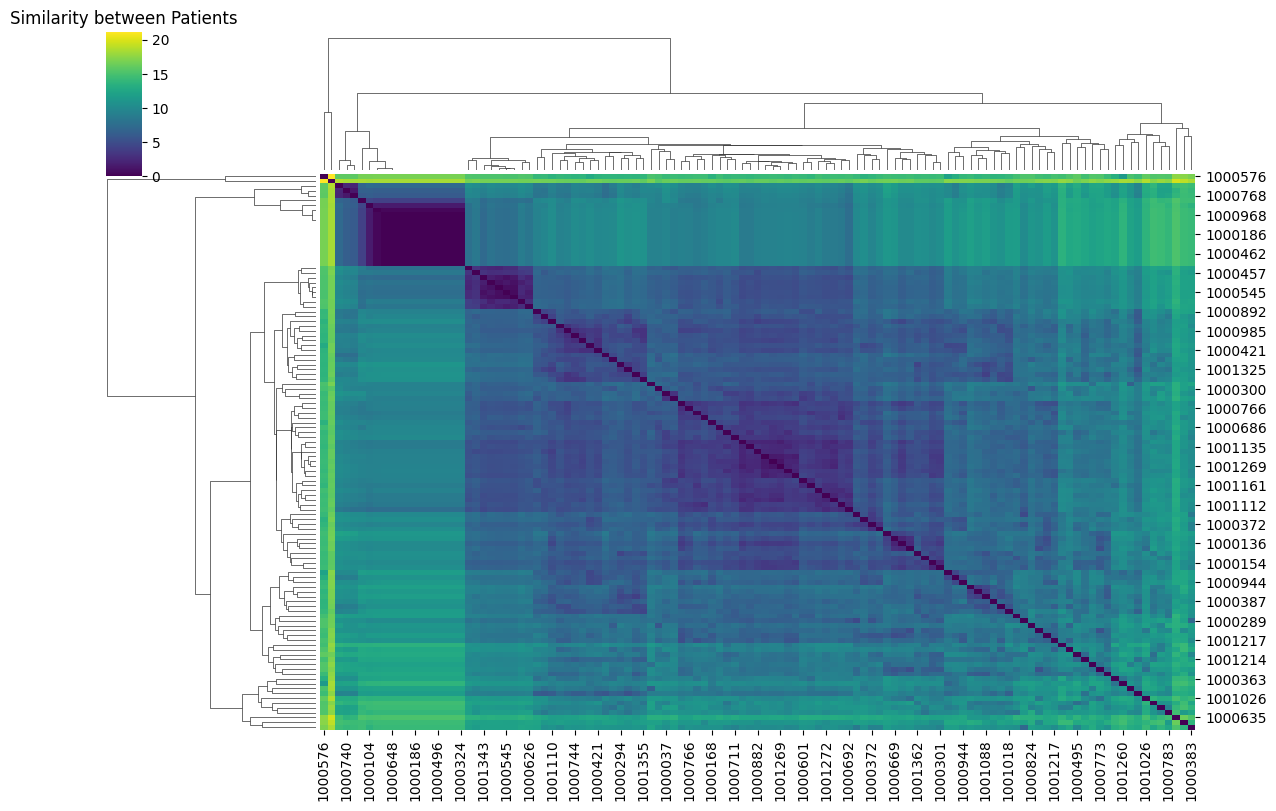

IndexError: index 51 is out of bounds for axis 0 with size 41

In [9]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import euclidean_distances
from sklearn.preprocessing import StandardScaler
from scipy.cluster import hierarchy

# Load data
dir_path = '/home/jagh/Documents/01_UB/MultiOmiX/patientomics/data/05_data_exploration/01_preprocessing_116_PLCP/'
filename = os.path.join(dir_path, 'lab_data_exploration.csv')
df = pd.read_csv(filename, sep=',', header=0, index_col=0)

# Extract the feature columns and sample data
feature_names = df.columns
samples = df.values

# Extract patients ids
patient_ids = df.index.values

# Standardize the data before calculating distances
scaler = StandardScaler()
scaled_samples = scaler.fit_transform(samples)

# Calculate pairwise Euclidean distances
similarities = euclidean_distances(scaled_samples)

# Debugging: Output non-finite values in the similarities matrix
nan_count = np.sum(np.isnan(similarities))
inf_count = np.sum(np.isinf(similarities))
print("Number of NaN values:", nan_count)
print("Number of infinite values:", inf_count)

# Replace NaN with infinity
similarities[np.isnan(similarities)] = np.inf

# Create a DataFrame with the similarities and feature names
similarities_df = pd.DataFrame(similarities, columns=patient_ids, index=patient_ids)

# Calculate linkage for hierarchical clustering
linkage = hierarchy.linkage(similarities, method='average', metric='euclidean')

# Set up the matplotlib figure, make it big!
plt.figure(figsize=(15, 10))

# Create a cluster map using seaborn
sns.clustermap(similarities_df, cmap='viridis', #row_cluster=True, col_cluster=True,
               row_linkage=linkage, col_linkage=linkage,
               figsize=(12, 8), 
               cbar_pos=(0.02, 0.8, 0.03, 0.18))

# Add feature names to the plot
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.title("Similarity between Patients")

# Show the plot
plt.show()


#################################
# Get the order of features based on the clustering
feature_order = hierarchy.leaves_list(linkage)

# Sort feature names according to the clustering order
sorted_feature_names = feature_names[feature_order]

# Display sorted feature names
print("Sorted Feature Names:", sorted_feature_names)
##################################

/tmp/ipykernel_13110/3769006963.py:33: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  patient_linkage = hierarchy.linkage(similarities, method='average', metric='euclidean')
/tmp/ipykernel_13110/3769006963.py:53: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  feature_linkage = hierarchy.linkage(feature_similarities, method='average', metric='euclidean')


<Figure size 1500x1000 with 0 Axes>

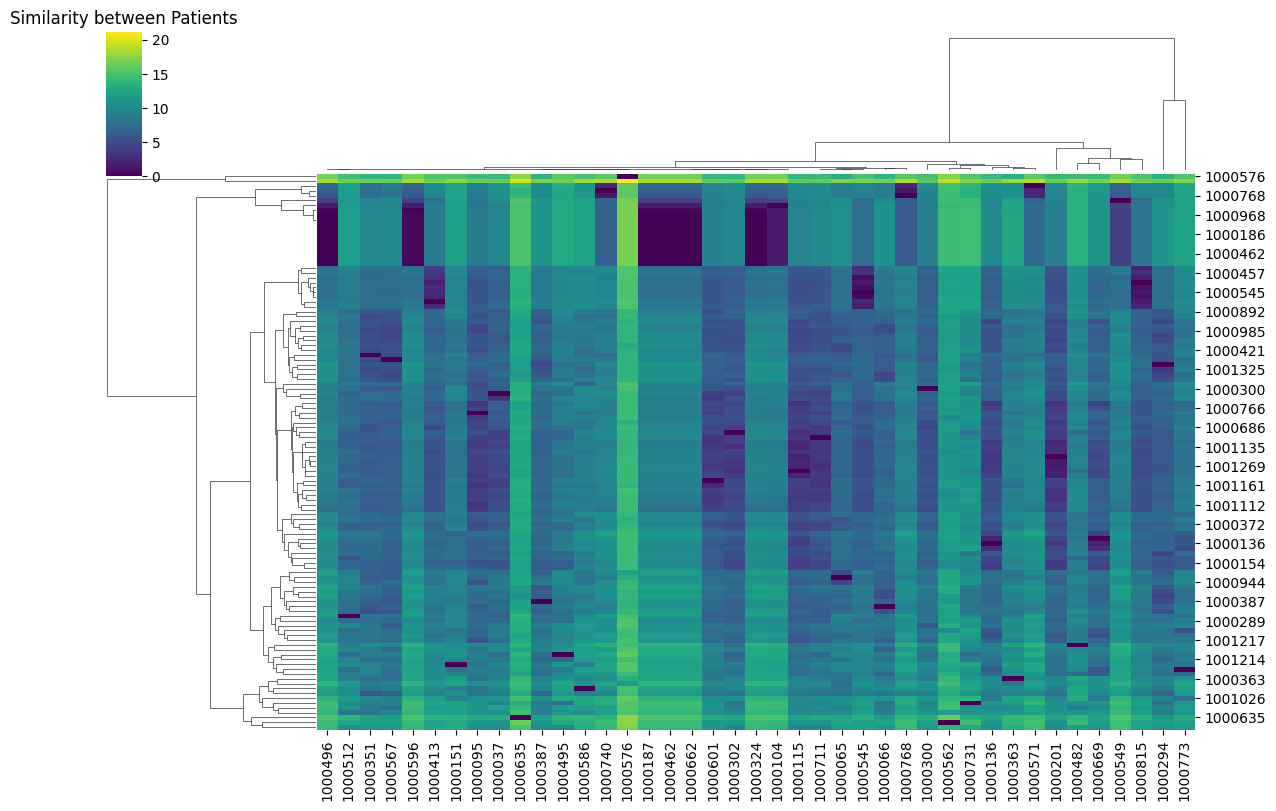

Sorted Feature Names: Index(['Leukozyten_0', 'Lymphozyten_0', 'Hämatokrit_0', 'Monozyten_0',
       'Normoblasten maschinell_0', 'Immature Granulozyten_0', 'Eosinophile_0',
       'Basophile_0', 'days_0', 'POCT-BNP_0', 'INR_0', 'Lactat arteriell_0',
       'Neutrophile Granulozyten_0', 'pH_0', 'Neutrophile_0', 'Erythrozyten_0',
       'Kalium_0', 'RDW_0', 'PCT hs_0', 'Glucose_0', 'Harnstoff_0',
       'Bicarbonat Std._0', 'Bicarbonat akt._0', 'aPTT_0', 'ALAT_0', 'MCH_0',
       'ASAT_0', 'pO2_0', 'G-Glutamyltransferase_0', 'MCV_0',
       'eGFR nach CKD-EPI_0', 'C-reaktives Protein_0', 'Hämoglobin_0',
       'Natrium_0', 'Ferritin ECLIA_0', 'LDH nach IFCC_0', 'Thrombozyten_0',
       'MCHC_0', 'Lactat-Dehydrogenase_0', 'Fibrinogen Clauss_0',
       'D-Dimere_0'],
      dtype='object')


In [10]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import euclidean_distances
from sklearn.preprocessing import StandardScaler
from scipy.cluster import hierarchy

# Load data
dir_path = '/home/jagh/Documents/01_UB/MultiOmiX/patientomics/data/05_data_exploration/01_preprocessing_116_PLCP/'
filename = os.path.join(dir_path, 'lab_data_exploration.csv')
df = pd.read_csv(filename, sep=',', header=0, index_col=0)

# Extract the feature columns and sample data
feature_names = df.columns
samples = df.values

# Extract patients ids
patient_ids = df.index.values

# Standardize the data before calculating distances
scaler = StandardScaler()
scaled_samples = scaler.fit_transform(samples)

# Calculate pairwise Euclidean distances
similarities = euclidean_distances(scaled_samples)

# Replace NaN with infinity
similarities[np.isnan(similarities)] = np.inf

# Calculate linkage for hierarchical clustering of patients
patient_linkage = hierarchy.linkage(similarities, method='average', metric='euclidean')

# Get the order of patients based on the clustering
patient_order = hierarchy.leaves_list(patient_linkage)

# Sort patient IDs according to the clustering order
sorted_patient_ids = patient_ids[patient_order]

# Create a DataFrame with the similarities and sorted patient IDs
# similarities_df = pd.DataFrame(similarities, columns=sorted_patient_ids, index=sorted_patient_ids)
# similarities_df = pd.DataFrame(similarities, columns=sorted_patient_ids, index=sorted_patient_ids)
similarities_df = pd.DataFrame(similarities, columns=patient_ids, index=patient_ids)

# Calculate the similarity matrix for features
feature_similarities = euclidean_distances(samples.T)

# Replace NaN with infinity
feature_similarities[np.isnan(feature_similarities)] = np.inf

# Calculate linkage for hierarchical clustering of features
feature_linkage = hierarchy.linkage(feature_similarities, method='average', metric='euclidean')

# Get the order of features based on the clustering
feature_order = hierarchy.leaves_list(feature_linkage)

# Sort feature names according to the clustering order
sorted_feature_names = feature_names[feature_order]

# Set up the matplotlib figure, make it big!
plt.figure(figsize=(15, 10))

# Create a cluster map using seaborn
sns.clustermap(similarities_df, cmap='viridis', row_cluster=True, col_cluster=True,
               row_linkage=patient_linkage, col_linkage=feature_linkage,
               figsize=(12, 8), cbar_pos=(0.02, 0.8, 0.03, 0.18))

# Add sorted feature names to the plot
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.title("Similarity between Patients")

# Show the plot
plt.show()

# Display sorted feature names
print("Sorted Feature Names:", sorted_feature_names)

/home/jagh/anaconda3/envs/patientomics/lib/python3.9/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


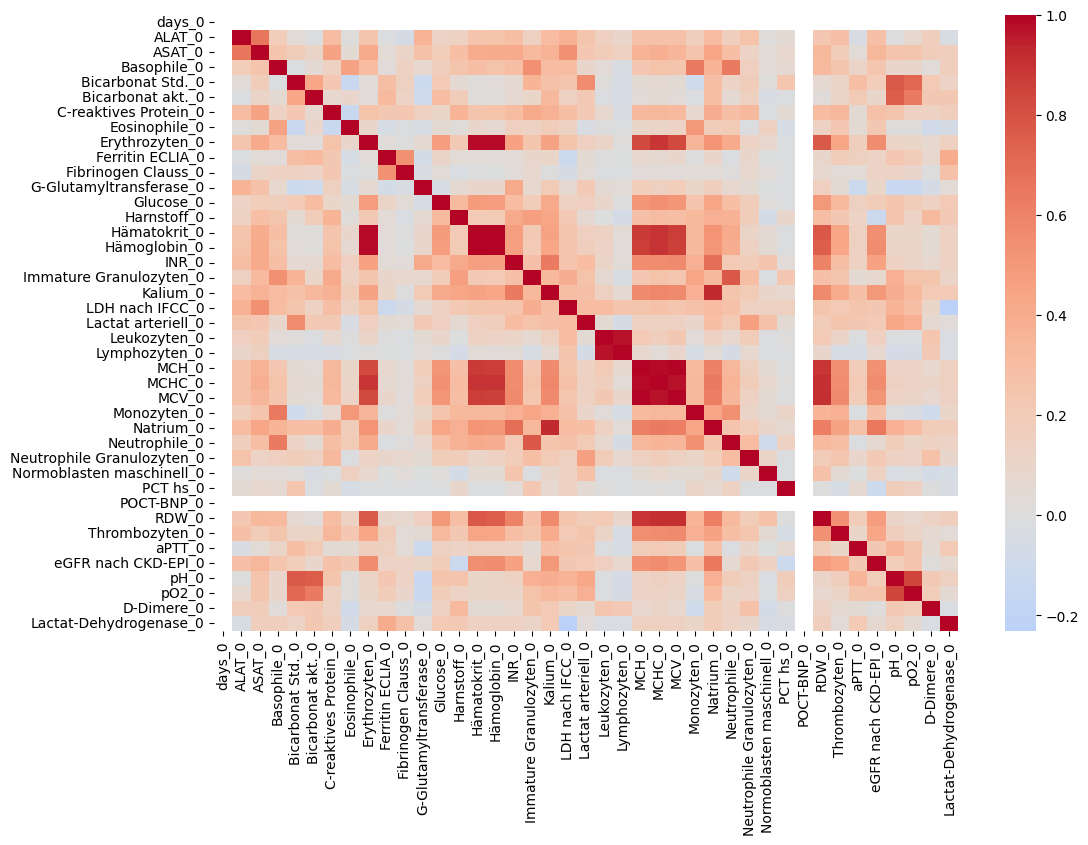

In [11]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances
from sklearn.manifold import MDS

# Load data
dir_path = '/home/jagh/Documents/01_UB/MultiOmiX/patientomics/data/05_data_exploration/01_preprocessing_116_PLCP/'
filename = os.path.join(dir_path, 'lab_data_exploration.csv')
df = pd.read_csv(filename, sep=',', header=0, index_col=0)

# Standardize the data before calculating distances
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)

# Calculate pairwise distances using Euclidean distance
similarities = pairwise_distances(scaled_data, metric='euclidean')

# Multidimensional scaling
seed = np.random.RandomState(seed=3)
mds = MDS(n_components=2, max_iter=5000, eps=1e-12, random_state=seed, dissimilarity='precomputed', n_jobs=1, metric=False)
pos = mds.fit_transform(similarities)

# Features as a heatmap
corr = df.corr()

# Set up the matplotlib figure, adjust size
plt.figure(figsize=(12, 8))

# Draw the heatmap using seaborn
sns.heatmap(corr, cmap='coolwarm', annot=False, fmt=".2f", center=0)

plt.show()

/home/jagh/anaconda3/envs/patientomics/lib/python3.9/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


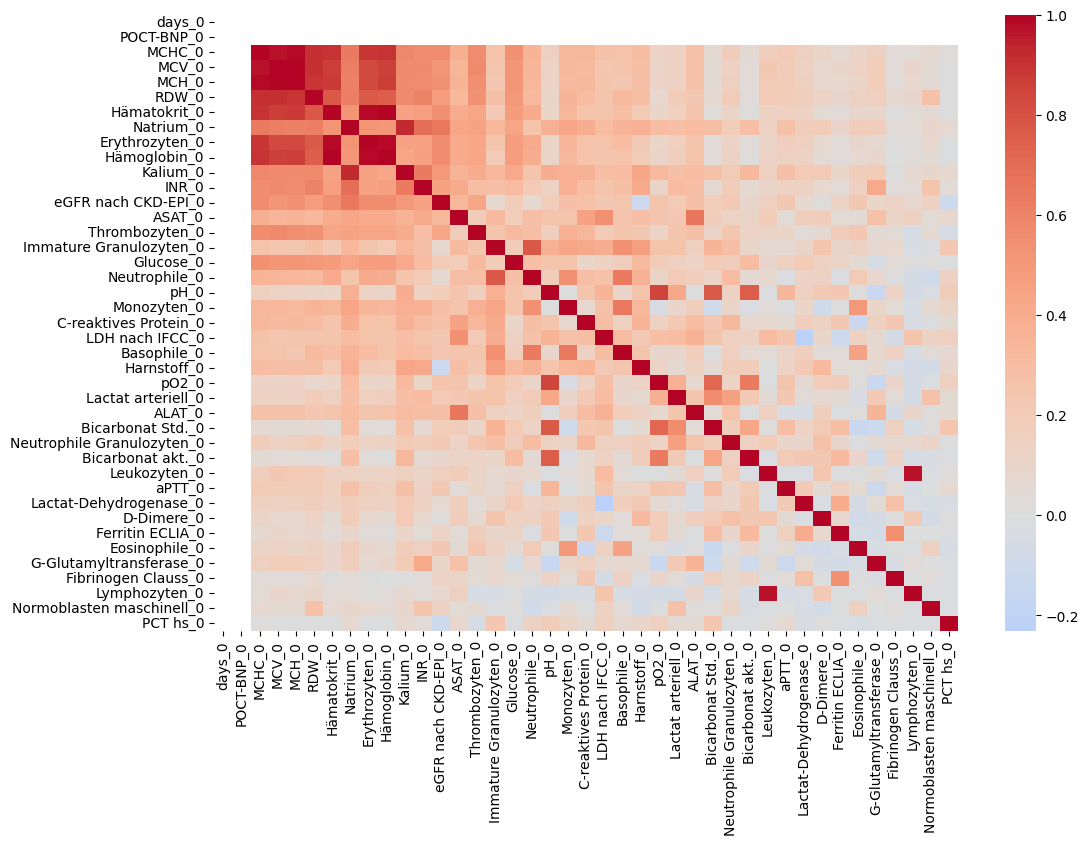

In [12]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances
from sklearn.manifold import MDS

# Load data
dir_path = '/home/jagh/Documents/01_UB/MultiOmiX/patientomics/data/05_data_exploration/01_preprocessing_116_PLCP/'
filename = os.path.join(dir_path, 'lab_data_exploration.csv')
df = pd.read_csv(filename, sep=',', header=0, index_col=0)

# Standardize the data before calculating distances
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)

# Calculate pairwise distances using Euclidean distance
similarities = pairwise_distances(scaled_data.T, metric='euclidean')  # Transpose to get feature distances

# Calculate average similarity distance for each feature
average_distances = np.mean(similarities, axis=0)

# Sort features based on their average similarity distances
sorted_indices = np.argsort(average_distances)
sorted_features = df.columns[sorted_indices]

# Reorder the dataframe columns based on sorted features
sorted_df = df[sorted_features]

# Multidimensional scaling
seed = np.random.RandomState(seed=3)
mds = MDS(n_components=2, max_iter=5000, eps=1e-12, random_state=seed, dissimilarity='precomputed', n_jobs=1, metric=False)
pos = mds.fit_transform(similarities)

# Features as a heatmap
corr = sorted_df.corr()

# Set up the matplotlib figure, adjust size
plt.figure(figsize=(12, 8))

# Draw the heatmap using seaborn
sns.heatmap(corr, cmap='coolwarm', annot=False, fmt=".2f", center=0)

plt.show()